In [1]:
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin
from scipy.interpolate import CubicSpline, PchipInterpolator
import matplotlib.pyplot as plt
import torch
from sklearn.preprocessing import StandardScaler
from torchcubicspline import natural_cubic_spline_coeffs
from torchcubicspline import NaturalCubicSpline

In [2]:
class GradientSMPA(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.05, epochs=100, random_state=7, verbose=False,
                 lambda_reg=0.0001, patience=10, decay_factor=0.9, min_learning_rate=1e-6,
                 n_control_points=6,
                 track_history=False):
        self.learning_rate = learning_rate
        self.initial_learning_rate = learning_rate
        self.epochs = epochs
        self.random_state = random_state
        self.verbose = verbose
        self.lambda_reg = lambda_reg
        self.patience = patience
        self.decay_factor = decay_factor
        self.min_learning_rate = min_learning_rate
        self.n_control_points = n_control_points
        self.track_history = track_history

        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        torch.manual_seed(random_state)
        np.random.seed(random_state)


    def _calculate_class_means(self, X, y):
        X_tensor = torch.tensor(X, device=self.device, dtype=torch.float32)
        y_tensor = torch.tensor(y, device=self.device, dtype=torch.float32)
        mask_1 = y_tensor == 1
        self.m1 = X_tensor[mask_1].mean(dim=0)
        self.m0 = X_tensor[~mask_1].mean(dim=0)

    def _initialize_control_points(self, X):
        n_features = X.shape[1] - 1
        X_tensor = torch.tensor(X, device=self.device, dtype=torch.float32)
        self.control_x = [torch.linspace(X_tensor[:, m].min(), X_tensor[:, m].max(), self.n_control_points, device=self.device)
                         for m in range(n_features)]
        self.control_y = [torch.nn.Parameter(torch.empty(self.n_control_points, device=self.device, dtype=torch.float32).uniform_(-0.1, 0.1),
                                            requires_grad=True)
                         for m in range(n_features)]
        self.initial_control_x = [cx.clone().detach() for cx in self.control_x]
        self.initial_control_y = [cy.clone().detach() for cy in self.control_y]

    def _fit_spline(self):

      self.splines = []
      for m in range(len(self.control_x)):
          sorted_idx = torch.argsort(self.control_x[m])
          cx = self.control_x[m][sorted_idx]  # Keep cx as 1D [n_control_points]
          cy = self.control_y[m][sorted_idx]

          # Only reshape cy to have an additional dimension
          cy = cy.unsqueeze(1)  # Shape becomes [n_control_points, 1]

          # Compute spline coefficients
          coeffs = natural_cubic_spline_coeffs(cx, cy)
          self.splines.append(NaturalCubicSpline(coeffs))


    def _calculate_displacement(self, X):
        X_tensor = torch.tensor(X, device=self.device, dtype=torch.float32)
        f_x = torch.zeros(X.shape[0], device=self.device, dtype=torch.float32)

        for m in range(len(self.splines)):
            feature_values = X_tensor[:, m]  # Extract the m-th feature
            # Evaluate the spline at these feature values
            spline_values = self.splines[m].evaluate(feature_values).squeeze()
            f_x += spline_values

        return X_tensor[:, -1] - f_x

    def _update_pseudo_labels(self, X, y):
        X_tensor = torch.tensor(X, device=self.device, dtype=torch.float32)
        f_m1 = torch.zeros(1, device=self.device, dtype=torch.float32)
        for m in range(len(self.splines)):
            # Create a tensor with just the m1 value we want to evaluate
            m1_tensor = self.m1[m].unsqueeze(0)  # Add batch dimension
            # Evaluate the spline and get the scalar value
            spline_value = self.splines[m].evaluate(m1_tensor).squeeze()
            f_m1 += spline_value

        displacement_m1 = self.m1[-1] - f_m1
        self.class_1_pseudo = 1 if displacement_m1 > 0 else -1
        self.class_0_pseudo = -self.class_1_pseudo
        y_tensor = torch.tensor(y, device=self.device, dtype=torch.float32)
        return torch.where(y_tensor == 1, self.class_1_pseudo, self.class_0_pseudo)

    def fit(self, X, y):
        if not set(np.unique(y)).issubset({0, 1}):
            raise ValueError("Labels must be 0 and 1")
        if X.shape[1] < 2:
            raise ValueError("Data must have at least 2 features")

        X = np.asarray(X)
        y = np.asarray(y)
        self._calculate_class_means(X, y)
        self._initialize_control_points(X)
        self._fit_spline()

        optimizer = torch.optim.Adam(self.control_y, lr=self.initial_learning_rate)
        current_lr = self.initial_learning_rate
        best_error = float('inf')
        best_control_y = None
        patience_counter = 0

        if self.track_history:
            self.error_history_ = []

        for epoch in range(self.epochs):
            optimizer.zero_grad()
            self._fit_spline()  # Update splines with current control_y
            pseudo_labels = self._update_pseudo_labels(X, y).float()
            displacements = self._calculate_displacement(X)

            # Loss: hinge-like loss for misclassifications
            errors = displacements * pseudo_labels <= 0
            loss = torch.mean(torch.relu(-displacements * pseudo_labels))

            # Regularization on control_y differences
            reg_loss = 0
            for cy in self.control_y:
                diff_y = cy[1:] - cy[:-1]
                reg_loss += self.lambda_reg * torch.sum(diff_y ** 2)
            loss += reg_loss

            loss.backward()
            optimizer.step()

            error_count = errors.sum().item()
            if self.verbose and epoch % 5 == 0:
                print(f"Epoch {epoch}: Errors = {error_count}, Loss = {loss.item():.4f}, LR = {current_lr:.6f}")

            if error_count < best_error:
                best_error = error_count
                best_control_y = [cy.clone().detach() for cy in self.control_y]
                self.class_1_pseudo_best = self.class_1_pseudo
                patience_counter = 0
                self.best_epoch = epoch
            else:
                patience_counter += 1
                if patience_counter >= self.patience:
                    current_lr = max(current_lr * self.decay_factor, self.min_learning_rate)
                    for param_group in optimizer.param_groups:
                        param_group['lr'] = current_lr
                    patience_counter = 0
                    if current_lr == self.min_learning_rate:
                        if self.verbose:
                            print(f"Min learning rate reached at epoch {epoch}")
                        break

            if self.track_history:
                self.error_history_.append(error_count)

        for m, cy in enumerate(best_control_y):
            self.control_y[m].data = cy
        self.class_1_pseudo = self.class_1_pseudo_best
        self._fit_spline()
        return self

    def predict(self, X):
        displacements = self._calculate_displacement(X)
        return np.where(displacements.detach().cpu().numpy() > 0,
                        1 if self.class_1_pseudo > 0 else 0,
                        0 if self.class_1_pseudo > 0 else 1)

    def predict_proba(self, X):
        displacements = self._calculate_displacement(X).detach().cpu().numpy()
        raw_probs = 1 / (1 + np.exp(-displacements * self.class_1_pseudo * 0.5))
        return np.column_stack([1 - raw_probs, raw_probs]) if self.class_1_pseudo > 0 else np.column_stack([raw_probs, 1 - raw_probs])

    def plot_convergence(self, figsize=(10, 4)):
        if not self.track_history or not hasattr(self, 'error_history_'):
            print("Convergence plotting requires track_history=True and a fitted model.")
            return None
        fig, ax = plt.subplots(figsize=figsize)
        ax.plot(self.error_history_, 'b-', label='Errors')
        ax.set_title('Error Convergence')
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Number of Errors')
        ax.grid(True)
        ax.legend()
        plt.tight_layout()
        return fig

In [3]:
import numpy as np
from sklearn.preprocessing import StandardScaler

def make_nd_dataset(n_samples=1000, n_features=3, dataset_type='twisted_spiral', noise=0.1, random_state=42):
    """
    Generate synthetic 3D or 4D classification datasets with non-linear boundaries.

    Parameters:
    - n_samples: Number of samples to generate.
    - n_features: Number of features (3 for 3D, 4 for 4D).
    - dataset_type: 'twisted_spiral', 'nested_spheres', or 'wavy_hyperplane'.
    - noise: Amount of random noise to add.
    - random_state: Seed for reproducibility.

    Returns:
    - X: Feature matrix (n_samples, n_features).
    - y: Labels (n_samples,).
    """
    if n_features not in [3, 4]:
        raise ValueError("n_features must be 3 or 4")
    np.random.seed(random_state)

    if dataset_type == 'twisted_spiral':
        # A spiral that twists through n-dimensional space
        t = np.linspace(0, 4 * np.pi, n_samples // 2)
        # Class 0: Inner spiral
        X0 = np.zeros((n_samples // 2, n_features))
        X0[:, 0] = 0.5 * t * np.cos(t)
        X0[:, 1] = 0.5 * t * np.sin(t)
        X0[:, 2] = 0.3 * t  # Linear growth in z
        if n_features == 4:
            X0[:, 3] = 0.2 * np.sin(2 * t)  # Wobble in 4th dim
        X0 += noise * np.random.randn(*X0.shape)

        # Class 1: Outer spiral
        X1 = np.zeros((n_samples // 2, n_features))
        X1[:, 0] = 0.7 * t * np.cos(t + np.pi)
        X1[:, 1] = 0.7 * t * np.sin(t + np.pi)
        X1[:, 2] = 0.3 * t + 0.5
        if n_features == 4:
            X1[:, 3] = 0.2 * np.cos(2 * t)
        X1 += noise * np.random.randn(*X1.shape)

        X = np.vstack([X0, X1])
        y = np.hstack([np.zeros(n_samples // 2), np.ones(n_samples // 2)])

    elif dataset_type == 'nested_spheres':
        # Concentric hyperspheres with separation in the last dimension
        r = np.random.uniform(0, 1, n_samples)  # Radius
        theta = np.random.uniform(0, 2 * np.pi, n_samples)  # Angles
        X = np.zeros((n_samples, n_features))
        X[:, 0] = r * np.cos(theta)
        X[:, 1] = r * np.sin(theta)

        if n_features == 3:
            X[:, 2] = np.where(r < 0.5, r, r + 0.5)  # Inner vs outer in z
        else:  # 4D
            phi = np.random.uniform(0, np.pi, n_samples)
            X[:, 2] = r * np.cos(phi)
            X[:, 3] = np.where(r < 0.5, r, r + 0.5)  # Separation in 4th dim

        X += noise * np.random.randn(*X.shape)
        y = (r < 0.5).astype(int)

    elif dataset_type == 'wavy_hyperplane':
        # A hyperplane with sinusoidal perturbations
        X = np.random.uniform(-1, 1, (n_samples, n_features))
        wave = np.sin(2 * np.pi * X[:, 0]) + np.cos(2 * np.pi * X[:, 1])
        if n_features == 4:
            wave += np.sin(2 * np.pi * X[:, 2])
        X[:, -1] = wave + np.random.randn(n_samples) * noise
        y = (X[:, -1] > wave).astype(int)

    else:
        raise ValueError("dataset_type must be 'twisted_spiral', 'nested_spheres', or 'wavy_hyperplane'")

    # Shuffle and standardize
    perm = np.random.permutation(n_samples)
    X, y = X[perm], y[perm]
    return X, y

In [4]:
X,y = make_nd_dataset(400, 3, 'wavy_hyperplane', 0.1)

In [5]:
print(y)

[1 0 0 1 1 0 1 0 1 1 0 1 0 1 1 0 0 1 0 1 1 1 0 1 0 0 1 0 1 0 1 1 1 1 0 1 1
 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 0 1 0 1 1 1 0 0 1 0 0 0 0 0 0 1 0 1 0 1 0
 0 0 0 1 1 0 0 0 1 0 0 1 1 1 1 1 0 1 0 1 0 1 1 0 0 1 0 1 1 0 0 1 1 1 1 0 1
 0 1 1 0 1 0 1 1 1 1 0 1 0 1 1 0 1 1 0 1 0 0 0 1 0 0 1 0 0 1 1 0 1 0 1 0 0
 0 1 0 1 0 0 0 0 0 1 1 1 1 0 0 1 0 0 1 0 0 1 1 0 0 0 0 1 0 1 1 1 0 0 1 1 1
 0 0 1 0 1 0 0 0 1 0 0 1 1 1 0 0 1 0 1 0 1 1 1 1 0 1 1 1 0 1 0 0 1 1 1 1 0
 0 1 1 0 1 0 0 1 0 1 0 1 1 0 0 0 1 1 1 0 1 0 1 0 1 1 0 1 0 0 1 1 0 0 0 0 0
 0 1 1 0 0 0 1 0 1 1 0 1 1 0 1 0 1 0 1 0 0 0 1 1 1 0 0 0 1 0 1 0 1 0 1 0 1
 1 1 1 0 1 0 0 0 1 1 1 1 1 0 0 1 0 1 0 0 0 1 1 1 0 1 0 0 0 0 1 1 0 0 1 0 1
 1 0 0 0 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 1 0 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 0
 0 1 0 1 1 1 0 1 1 0 1 1 0 1 0 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0]


In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 5)

scaler = MinMaxScaler(feature_range=(-100,100))
X_train_minmax = scaler.fit_transform(X_train)
X_test_minmax = scaler.transform(X_test)

Fitting 3 folds for each of 60 candidates, totalling 180 fits


/home/soulangel443/.local/share/mise/installs/python/latest/lib/python3.12/site-packages/torchcubicspline/interpolate.py:277: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/BucketizationUtils.h:32.)
  index = torch.bucketize(t.detach(), self._t) - 1
/home/soulangel443/.local/share/mise/installs/python/latest/lib/python3.12/site-packages/torchcubicspline/interpolate.py:277: UserWarning: torch.searchsorted(): input value tensor is non-contiguous, this will lower the performance due to extra data copy when converting non-contiguous tensor to contiguous, please use contiguous input value tensor if possible. This message will only appear once per program. (Triggered internally at ../aten/src/ATen/native/Bucketi

Best parameters: {'epochs': 300, 'lambda_reg': 1e-08, 'learning_rate': 0.01, 'n_control_points': 8}
Best CV accuracy: 0.5375007347322636

GradientSMPA Grid Search Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.57      0.54        35
           1       0.63      0.58      0.60        45

    accuracy                           0.57        80
   macro avg       0.57      0.57      0.57        80
weighted avg       0.58      0.57      0.58        80



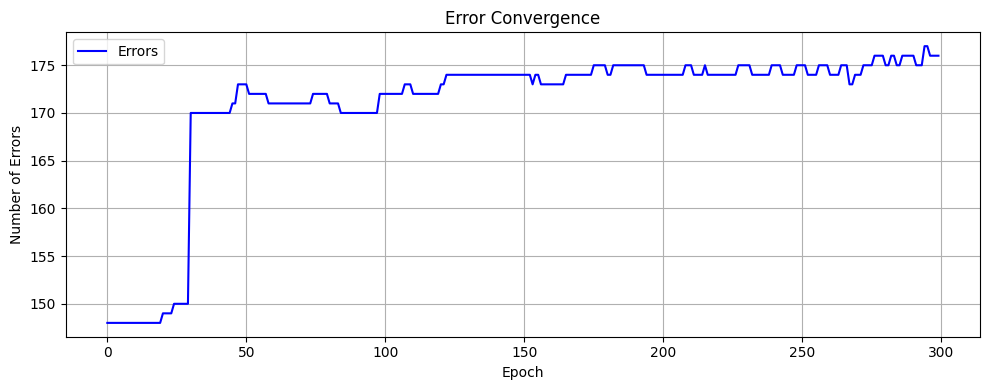

In [7]:
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1, 0.2],           # Around your 0.1
    'epochs': [300],                   # Bracket your 300
    'n_control_points': [8, 10, 15, 20, 30],            # More points worked for you
    'lambda_reg': [1e-8, 1e-6, 1e-4],           # Ultra-light regularization
}

# Initialize model with your base settings
smpa = GradientSMPA(
    learning_rate=0.1,        # Moderate step size for gradient updates
    epochs=300,                # Enough iterations to converge
    random_state=9,           # Reproducibility
    verbose=False,              # Track progress
    lambda_reg=0.00000001,
    patience=15,                # Standard patience for LR decay
    decay_factor=0.95,
    min_learning_rate=1e-6,    # Stop when LR gets tiny
    n_control_points=30,        # Flexible but not overkill
    track_history=True
)

# Grid search
grid_search = GridSearchCV(smpa, param_grid, cv=3, scoring='accuracy',
n_jobs=-1, verbose = 1)
grid_search.fit(X_train_minmax, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best CV accuracy:", grid_search.best_score_)

# Test set evaluation
y_pred = grid_search.predict(X_test_minmax)
print("\nGradientSMPA Grid Search Classification Report:")
print(classification_report(y_test, y_pred))

# Plot convergence for best model (after refitting manually if needed)
best_model = grid_search.best_estimator_
best_model.plot_convergence()
plt.show()

In [8]:
test_score = best_model.score(X_test_minmax, y_test)
print("Test score with best model: ", test_score)

Test score with best model:  0.575


In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
from sklearn.svm import SVC

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
    'kernel': ['rbf', 'linear', 'poly', 'sigmoid']  # Explicitly set to 'rbf'
}

# Create an instance of SVM
svm = SVC(random_state=4)

# Instantiate the GridSearchCV object:
# - 'svm' is the estimator
# - 'param_grid' defines the parameters to try
# - 'cv=5' means 5-fold cross-validation
# - 'scoring='accuracy'' uses accuracy to compare model performance
# - 'n_jobs=-1' uses all processors for computation
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

# Fit GridSearchCV to find the best parameters
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best parameters found: ", best_params)
print("Best cross-validation score: ", best_score)

# Evaluate the best model on the test set
best_model_new = grid_search.best_estimator_
test_score = best_model_new.score(X_test_scaled, y_test)
print("Test set score with best model: ", test_score)

y_pred = best_model_new.predict(X_test_scaled)

# Print classification report
print("SVM Classification Report:")
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best parameters found:  {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best cross-validation score:  0.578125
Test set score with best model:  0.5375
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.20      0.27        35
           1       0.56      0.80      0.66        45

    accuracy                           0.54        80
   macro avg       0.50      0.50      0.47        80
weighted avg       0.51      0.54      0.49        80

